In [4]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
nltk.download('vader_lexicon')
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from tqdm import tqdm
from datetime import datetime

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mehdimouden/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_6714/3052469637.py:9: DtypeWarning: Columns (0,1,2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tweets.csv', sep=';')


,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0.0,0.0,0.0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co...
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasn't caught in the s...
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


1. Pre-processing of the tweets

In [ ]:
# Load your CSV data into a DataFrame
df = pd.read_csv('tweets.csv', sep=';')
df.head()

In [7]:
# Define a function to preprocess the text by removing hashtags, non-English characters, and URLs
def preprocess_text(text):
    if isinstance(text, str): 
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove non-English alphabet characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
    else:
        text = ''
    return text

In [8]:
# Apply the preprocessing function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)
df.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0.0,0.0,0.0,appena uscito un nuovo video LES CRYPTOMONNAIE...
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano Digitize Currencies EOS ROI ATampT Bit...
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasnt caught in the st...
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices BTC USD ETH USD LTC USD ...
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv Nosar Baz BITCOIN Is An Asset amp NOT A C...


2. Sentiment Analysis with VADER

In [9]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [10]:
# Create a function to apply VADER sentiment analysis and add sentiment scores to the DataFrame
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment
# Create a function to calculate weights for each tweet
def calculate_weights(tweet):
    weight = tweet['likes'] + tweet['retweets'] + tweet['replies']
    return weight if weight > 0 else 1  # Ensure a non-zero minimum weight
# Create a function to calculate weighted average sentiment
def weighted_average(group):
    weighted_sentiments = group['compound_sentiment'] * group['weight']
    return weighted_sentiments.sum() / group['weight'].sum()


In [11]:
# Apply the sentiment analysis function to the preprocessed 'text' column
df['sentiment'] = df['text'].apply(get_sentiment)
df['compound_sentiment'] = df['sentiment'].apply(lambda x: x['compound'])
df.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text,sentiment
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0.0,0.0,0.0,appena uscito un nuovo video LES CRYPTOMONNAIE...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano Digitize Currencies EOS ROI ATampT Bit...,"{'neg': 0.123, 'neu': 0.877, 'pos': 0.0, 'comp..."
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasnt caught in the st...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices BTC USD ETH USD LTC USD ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv Nosar Baz BITCOIN Is An Asset amp NOT A C...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp..."


In [184]:
# Convert the 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate weights for each tweet
df['weight'] = df.apply(calculate_weights, axis=1)
# Group the tweets published on the same day using their weights
df_vader = df.groupby(df['timestamp'].dt.date).apply(weighted_average).reset_index()
df_vader.columns = ['timestamp', 'weighted_avg_sentiment']

# Print the resulting df_vader DataFrame
print(df_vader)

KeyboardInterrupt: 

In [185]:
# Convert the 'timestamp' column in df_vader to the desired date format
df_vader['timestamp'] = pd.to_datetime(df_vader['timestamp'], format='%Y-%m-%d')

# Calculate the rolling minimum and maximum over a 1-year window
rolling_min = df_vader['weighted_avg_sentiment'].rolling(365, min_periods=1).min()
rolling_max = df_vader['weighted_avg_sentiment'].rolling(365, min_periods=1).max()

# Apply min-max scaling to the 'weighted_avg_sentiment' column
df_vader['scaled_sentiment'] = (df_vader['weighted_avg_sentiment'] - rolling_min) / (rolling_max - rolling_min)

# Create a Timestamp object for '01-01-2014' with time set to midnight
date_threshold = pd.Timestamp(datetime(2018, 1, 1, 0, 0))
# Filter df_vader
filtered_df_vader = df_vader[df_vader['timestamp'] >= date_threshold]
# Print the resulting DataFrame with scaled sentiment
print(filtered_df_vader)

      timestamp  weighted_avg_sentiment  scaled_sentiment
2313 2018-01-01                0.127589          0.572448
2314 2018-01-02                0.218285          0.653416
2315 2018-01-03                0.083549          0.533132
2316 2018-01-04                0.389383          0.806159
2317 2018-01-05                0.459835          0.869054
2318 2018-01-06                0.336470          0.758923
2319 2018-01-07                0.449501          0.859829
2320 2018-01-08                0.178211          0.617640
2321 2018-01-09               -0.056995          0.407665
2322 2018-01-10                0.043662          0.497524
2323 2018-01-11               -0.037481          0.425086
2324 2018-01-12                0.193341          0.631147
2325 2018-01-13                0.158148          0.599730
2326 2018-01-14               -0.064756          0.400737
2327 2018-01-15                0.068649          0.519831
2328 2018-01-16               -0.144125          0.329882
2329 2018-01-1

3. Import BTC data

In [169]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Bitcoin
btc_ticker = "BTC-USD"

# Define the date range for which you want to fetch historical data
start_date = "2018-01-01"
end_date = "2019-11-23"

# Fetch historical data for Bitcoin
btc_data = yf.download(btc_ticker, start=start_date, end=end_date)

# Extract the 'Close' prices from btc_data
btc_prices = btc_data['Close']
# Print the resulting DataFrame
btc_data.head()

[*********************100%%**********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   
2018-01-06  17462.099609  17712.400391  16764.599609  17527.000000   
2018-01-07  17527.300781  17579.599609  16087.700195  16477.599609   
2018-01-08  16476.199219  16537.900391  14208.200195  15170.099609   
2018-01-09  15123.700195  15497.500000  14424.000000  14595.400391   
2018-01-10  14588.500000  14973.299805  13691.200195  14973.299805   
2018-01-11  14968.200195  15018.799805  13105.900391  13405.799805   
2018-01-12  13453.900

In [194]:
# Make sure both DataFrames have the same date index

#filtered_df_vader = filtered_df_vader.set_index('timestamp')
#btc_prices = btc_prices.set_index('Date')
# Set the index of btc_prices to match the index of filtered_df_vader
btc_prices = btc_prices.reindex(filtered_df_vader.index)
#filtered_df_vader['scaled_sentiment'] = 2*filtered_df_vader['scaled_sentiment']-1
print(filtered_df_vader, btc_prices)

            weighted_avg_sentiment  scaled_sentiment
timestamp                                           
2018-01-01                0.127589          0.144896
2018-01-02                0.218285          0.306832
2018-01-03                0.083549          0.066265
2018-01-04                0.389383          0.612319
2018-01-05                0.459835          0.738109
2018-01-06                0.336470          0.517846
2018-01-07                0.449501          0.719658
2018-01-08                0.178211          0.235281
2018-01-09               -0.056995         -0.184669
2018-01-10                0.043662         -0.004952
2018-01-11               -0.037481         -0.149829
2018-01-12                0.193341          0.262294
2018-01-13                0.158148          0.199459
2018-01-14               -0.064756         -0.198527
2018-01-15                0.068649          0.039662
2018-01-16               -0.144125         -0.340237
2018-01-17                0.170902          0.

4. Portfolio strategies

4.1 Statistical Analysis 

In [196]:
# Calculate the daily returns for BTC
btc_data['daily_return'] = btc_data['Adj Close'].pct_change()
# Create the 'updown' column
btc_data['updown'] = (btc_data['daily_return'] > 0).astype(int)
# Calculate the correlation between scaled sentiment and daily returns
correlation = filtered_df_vader['scaled_sentiment'].corr(btc_data['daily_return'].reindex(filtered_df_vader.index))
correlation_2 = filtered_df_vader['scaled_sentiment'].corr(btc_data['updown'].reindex(filtered_df_vader.index))
# Print the correlation
print(f"Correlation between scaled sentiment and daily return on BTC: {correlation:.3f}")
print(f"Correlation between scaled sentiment and movement of BTC price: {correlation_2:.3f}")

Correlation between scaled sentiment and daily return on BTC: 0.051
Correlation between scaled sentiment and movement of BTC price: 0.014


4.2 Portfolio strategy 1 : Naïve approach

In [197]:
# Define the initial portfolio balance in USD
initial_balance = 100000
total_portfolio_value = 100000

# Initialize portfolio variables
portfolio_balance = initial_balance
btc_holdings = 0

# Create lists to store the portfolio values and BTC holdings over time
portfolio_values_1 = []
btc_holdings_values_1 = []

# Iterate through the 'filtered_df_vader' DataFrame
for index, row in filtered_df_vader.iterrows():
    scaled_sentiment = row['scaled_sentiment']
    btc_price = btc_prices.loc[index]  # Get the BTC price for the current date

    # Calculate the amount to invest in BTC based on scaled sentiment
    investment_in_btc = scaled_sentiment * total_portfolio_value - btc_holdings * btc_price

    # Update BTC holdings and portfolio balance
    btc_holdings += investment_in_btc / btc_price
    portfolio_balance -= investment_in_btc

    # Calculate the total portfolio value
    total_portfolio_value = portfolio_balance + (btc_holdings * btc_price)

    # Append values to the lists
    portfolio_values_1.append(total_portfolio_value)
    btc_holdings_values_1.append(btc_holdings)

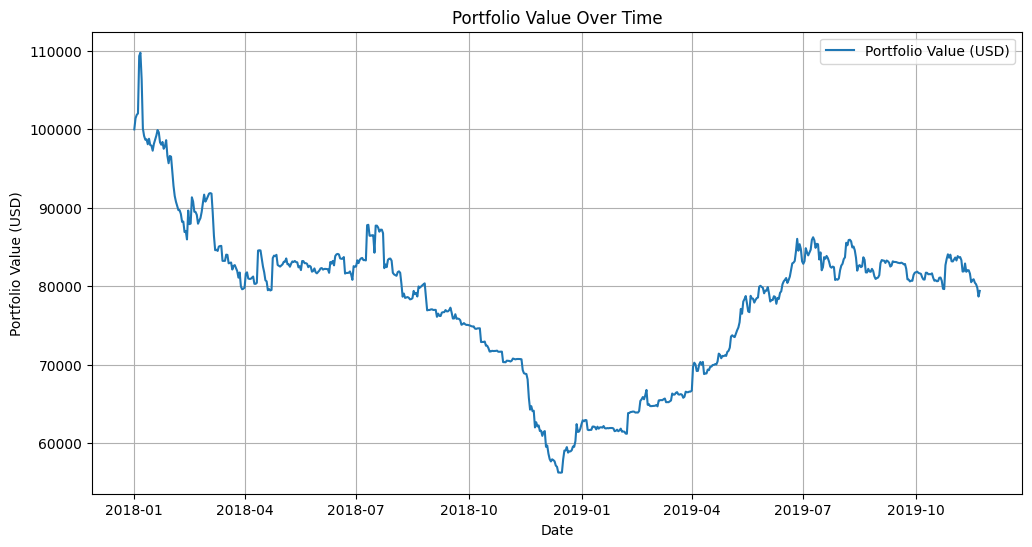

In [198]:
import matplotlib.pyplot as plt

# Plot the portfolio value in USD
plt.figure(figsize=(12, 6))
plt.plot(filtered_df_vader.index, portfolio_values_1, label='Portfolio Value (USD)')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

5. Comparison with FinBERT --- DOESNT WORK YET

In [22]:
# Initialize finBERT sentiment model
finbert_model_name = "ProsusAI/finbert"
max_length = 512  # You can adjust this value as needed
finbert_tokenizer = BertTokenizer.from_pretrained(finbert_model_name, max_length=max_length)
finbert_model = BertForSequenceClassification.from_pretrained(finbert_model_name)

In [23]:
# Function to compute finBERT sentiment scores
def compute_finbert_sentiment(text):
    tokens = finbert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
    
    with torch.no_grad():
        output = finbert_model(**tokens)
        logit = output.logits
    return logit

In [55]:
import numpy as np
df['finbert_sentiment'] = np.zeros(len(df['text']))

#for i in range(1000):
    #df['finbert_sentiment'][i] = compute_finbert_sentiment(df['text'][i])
df['finbert_sentiment'][1] = compute_finbert_sentiment(df['text'][1])
#print(df['finbert_sentiment'][1])
#df['finbert_sentiment'][i] = df['text'][i].apply(compute_finbert_sentiment)
# Extract the sentiment score from finBERT results
# df['finbert_score'] = df['finbert_sentiment'].apply(lambda x: x[0][0].item())
df.head()

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_6714/3092863782.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['finbert_sentiment'][1] = compute_finbert_sentiment(df['text'][1])


AttributeError: 'torch.dtype' object has no attribute 'kind'

In [ ]:
# Print the DataFrame with sentiment scores
print(df[['text', 'compound_score', 'finbert_score']])

In [58]:
import pandas as pd

ModuleNotFoundError: No module named 'finbert'

In [63]:
# Select the first 1000 tweets


OSError: yiyangiliu/finbert is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`